# AlexNet

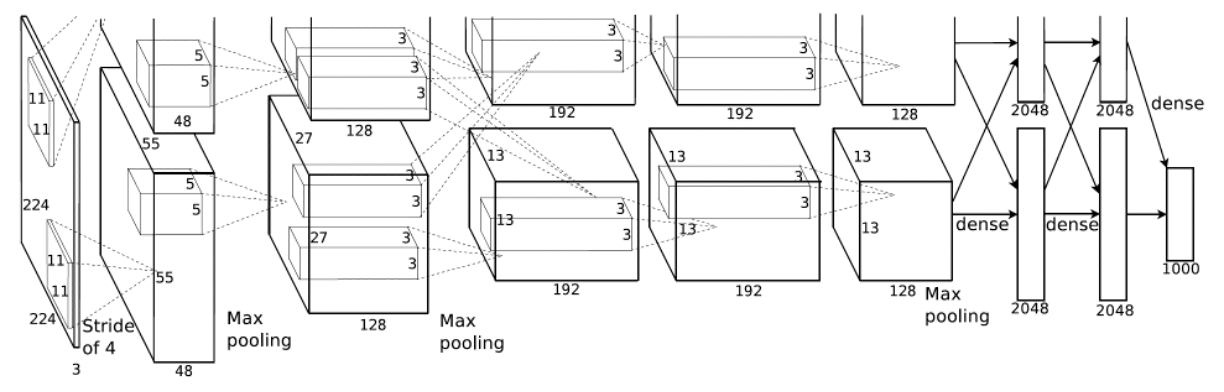



In [1]:
import torch

device = torch.device('cuda')
torch.cuda.is_available()

True

In [2]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

fashion_mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224) # 1*28*28 -> 1 * 224 * 224
])

download_root = './'

train_dataset = FashionMNIST(download_root, transform = fashion_mnist_transform, train= True, download = True)
test_dataset = FashionMNIST(download_root, transform = fashion_mnist_transform, train= False, download = True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [3]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle = True)

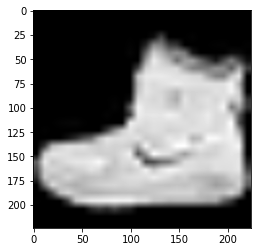

In [4]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[0][0][0].numpy(),
           cmap = 'gray')

In [5]:
from torch import nn


# model = nn.Sequential(
#     convolution,
#     fully connected,
#     ReLU
# )

class AlexNet(nn.Module) :
  def __init__(self):
    super().__init__()
    self.CNN = nn.Sequential(
        
            nn.Conv2d(in_channels = 1, out_channels = 48, kernel_size = 11, stride = 4, padding = 0),
            nn.ReLU(inplace = True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size = 3, stride = 2),

            nn.Conv2d(in_channels = 48, out_channels = 128, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace = True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size = 3, stride = 2),

            nn.Conv2d(in_channels = 128, out_channels = 192, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.LocalResponseNorm(size=5, k=2),

            nn.Conv2d(in_channels = 192, out_channels = 192, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.LocalResponseNorm(size=5, k=2),
            
            nn.Conv2d(in_channels = 192, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
    )

    self.FC = nn.Sequential(
        
        nn.Linear(128*6*6,2048),
        nn.ReLU(True),
        nn.Dropout(0.5),

        nn.Linear(2048,2048),
        nn.ReLU(True),
        nn.Dropout(0.5),

        nn.Linear(2048, 10),
        nn.Softmax()
    )

  def forward(self, inp) :
    cnn_res = self.CNN(inp)
      
    #flatten 128* 6* 6 -> 00000(한줄로 나열)
    flatten = torch.flatten(cnn_res,1)
    fc_res = self.FC(flatten)
    return fc_res

In [6]:
from torch import optim

def train(model, epochs) :
  
  # optimizer setting
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  
  # Loss function
  criterion = nn.CrossEntropyLoss() # classification 분류 -> 여러개 중에서 하나를 고르는 문제기 때문에

  for epoch in range(epochs) :
    model.train() # 모델을 train상태로 만들기
    train_accaracy = 0.0

    for batch_ind, samples in enumerate(train_loader) :
      x_t, y_t = samples

      #device로 x_t, y_t를 보냄
      x_t, y_t = x_t.to(device), y_t.to(device)

      #x_t를 넣어서 predicted
      pred = model(x_t)

      # predicted랑 y_t랑 비교 -> 둘의 차이(loss 계산)
      loss = criterion(pred, y_t)

      # loss 값을 가지고 back-propagation을 진행 -> weight값 업데이트
      # optimizer가 해줌
      optimizer.zero_grad() # optimizer 초기화
      loss.backward() # 역전파 실행
      optimizer.step()

    # accuary test for train dataset
    model.eval() # 모델을 평가 상태로 변경
    correct = 0
    for xx, yy in train_loader:
      data, target = xx.to(device), yy.to(device)
      pred = model(data) # pred [0, 0, 0.1, 0.2, 0.1 ... 0] -> 합이 1이 되도록 나타남(Softmax로 인해)
      _, predicted = torch.max(pred, 1)
      correct += predicted.eq(target.data).sum()

    print("train accuracy : ", (100 * correct / len(train_loader.dataset)).item())

train(model, 30) -> 알아서 30(epoch)만큼 train실행

In [7]:
alexnet = AlexNet()
alexnet.to(device)
train(alexnet, 10)

RuntimeError: ignored

In [ ]:
def get_n_params(model) :
  pp = 0
  for p in list(model.parameters()) :
    nn = 1
    for s in list(p.size()) :
      nn = nn*s
    pp += nn
  return pp


In [ ]:
get_n_params(alexnet)

In [ ]:
alexnet.eval() # 모델을 평가 상태로 변경
correct = 0
for xx, yy in train_loader:
  data, target = xx.to(device), yy.to(device)
  pred = alexnet(data) # pred [0, 0, 0.1, 0.2, 0.1 ... 0] -> 합이 1이 되도록 나타남(Softmax로 인해)
  _, predicted = torch.max(pred, 1)
  correct += predicted.eq(target.data).sum()

print("train accuracy : ", (100 * correct / len(train_loader.dataset)).item())


In [ ]:
alexnet

# Convolution Layer를 증가시키면 성능이 증가하는가?

In [ ]:
# Fashion MNIST

class Anet(nn.Module) :

  def __init__(self) :
    super().__init__()
    # CNN
    self.CNN = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace = True),

        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace = True),

        nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
    
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace = True),

        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace = True),

        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 1, stride = 1, padding = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
    )

    # FC 
    self.FC = nn.Sequential(
        nn.Linear(64*29*29,256),
        nn.ReLU(True),
        nn.Dropout(0.2),

        nn.Linear(256,64),
        nn.ReLU(True),
        nn.Dropout(0.2),

        nn.Linear(64, 10),
        nn.Softmax()
    )
  
  def forward(self, inp) :
    cnn_res = self.CNN(inp)
    flatten = torch.flatten(cnn_res, 1)  # Flatten
    fc_res = self.FC(flatten) # FC
    return fc_res

In [ ]:
aaa = Anet()

In [ ]:
get_n_params(aaa)

In [ ]:
from torchsummary import summary

aaa.to(device)

summary(aaa, (1,224,224), batch_size=64)

train(aaa, 10)